In [ ]:
# default_exp models.prob

# models.prob

> API details.

In [ ]:
# export
import numpy as np
import torch
from torch import nn
from fastrenewables.tabular.model import *
from fastai.tabular.data import *
from fastrenewables.timeseries.model import *
from fastai.tabular.all import *
from torch.autograd import Variable
import pandas as pd
from fastrenewables.losses import *
from fastai.losses import MSELossFlat

In [ ]:
def x_to_y(X):
    return np.sin(X)
#     return X*0.5

def make_data(numsamp):

    X = np.linspace(-3, 3, numsamp)
    y = x_to_y(X)

    y += np.random.randn(*y.shape) * np.linspace(0, .3, len(y))
   
    return pd.DataFrame({"X": X, "y":y})

In [ ]:
# export
class MeanStdWrapper(nn.Module):
    def __init__(self, model, last_layer_size):
        super().__init__()
        self.model = model
        self.decoder = nn.Linear(last_layer_size, 2)

        
    def forward(self, categorical_data, continuous_data):
        x = self.model(categorical_data, continuous_data)
        x = self.decoder(x)
        mean = x[:,0].reshape(-1,1)

        if self.training:
            var = x[:,1].reshape(-1,1)
        else:
            var = x[:,1].reshape(-1,1).exp()
            
        return (mean, var)


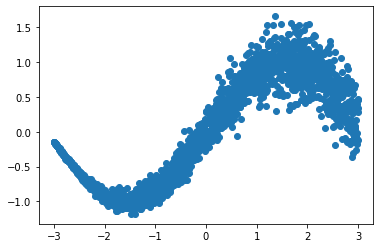

In [ ]:
N = 2000
df  = make_data(N)
plt.scatter(df.X, df.y)
plt.show()

In [ ]:
dls = TabularDataLoaders.from_df(df, x_names="X", y_names="y", deivce="cpu", bs=N//10)

In [ ]:
cat, x, y = dls.one_batch()

In [ ]:
ann_structure = [1, 50, 10]
model = MultiLayerPerceptron(ann_structure)
# model = MultiLayerPerceptron(ann_structure + [1])
model = MeanStdWrapper(model, ann_structure[-1])
model
          

MeanStdWrapper(
  (model): MultiLayerPerceptron(
    (final_activation): Identity()
    (embeds): ModuleList()
    (emb_drop): Dropout(p=0.0, inplace=False)
    (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): LinBnDrop(
        (0): Linear(in_features=1, out_features=50, bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): LinBnDrop(
        (0): Linear(in_features=50, out_features=10, bias=True)
      )
    )
  )
  (decoder): Linear(in_features=10, out_features=2, bias=True)
)

In [ ]:
learner = Learner(dls, model, loss_func=GaussianNegativeLogLikelihoodLoss())
# learner = Learner(dls, model, loss_func=MSELossFlat())

In [ ]:
learner.fit(100, lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.023855,0.314391,00:00
1,0.011638,0.244297,00:00
2,-0.000923,0.225207,00:00
3,-0.010148,0.213270,00:00
4,-0.019780,0.203111,00:00
5,-0.029272,0.203674,00:00
6,-0.039617,0.203282,00:00
7,-0.049561,0.207249,00:00
8,-0.062102,0.216655,00:00
9,-0.076296,0.215660,00:00


In [ ]:
x_axis = torch.linspace(-3,3,201).view(-1,1)
with torch.no_grad():
    mean, var = learner.model.to("cpu")(None, x_axis)
#     mean = learner.model.to("cpu")(None, x_axis)
#     mean = learner.model.to("cpu")(None, x_axis)
x_axis.shape, mean.shape

(torch.Size([201, 1]), torch.Size([201, 1]))

(-3.0, 3.0)

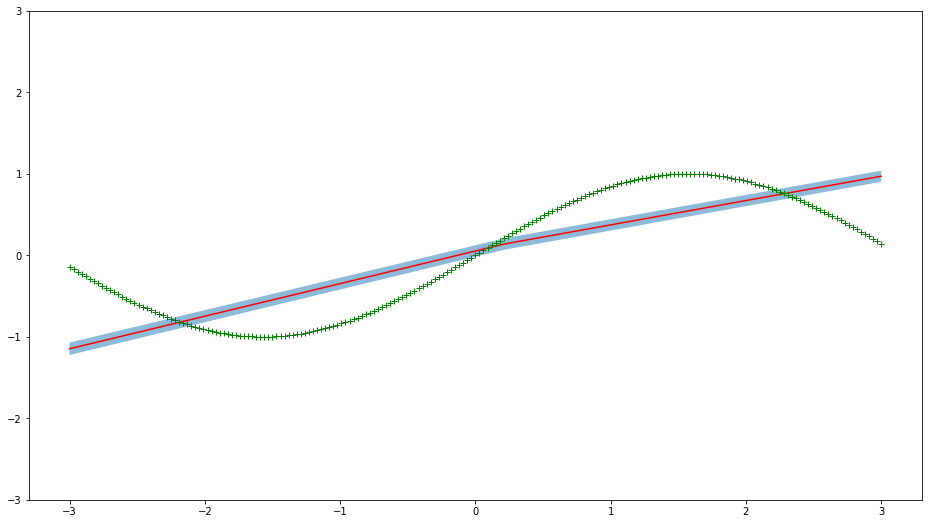

In [ ]:
plt.figure(figsize=(16,9))
plt.plot( x_axis.numpy().flatten(), mean.numpy().flatten(), 'r')
plt.plot( x_axis.numpy().flatten(), x_to_y(x_axis).numpy().flatten(), 'g+')
plt.fill_between(x_axis.numpy().flatten(), mean.numpy().flatten()-var.numpy().flatten()**0.5, mean.numpy().flatten()+var.numpy().flatten()**0.5, alpha=0.5)
plt.ylim(-3,3)